# • Getting Started

This notebook provides an example on how to start using the main functionalities of the NeuralForecast library. The `core.NeuralForecast` class allows users to easily interact with `models.NeuralForecast` PyTorch models. In this example we will forecast AirPassengers data with a classic `LSTM` and the recent `NHITS` models. The full list of available models is available [here](https://nixtla.github.io/neuralforecast/models.html).


You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Getting_Started_with_NBEATS_and_NHITS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing NeuralForecast

In [ ]:
%%capture
!pip install git+https://github.com/Nixtla/neuralforecast.git@main

In [ ]:
%%capture
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN
from neuralforecast.utils import AirPassengersDF

## 2. Loading AirPassengers Data

The `core.NeuralForecast` class contains shared, `fit`, `predict` and other methods that take as inputs pandas DataFrames with columns `['unique_id', 'ds', 'y']`, where `unique_id` identifies individual time series from the dataset, `ds` is the date, and `y` is the target variable. 

In this example dataset consists of a set of a single series, but you can easily fit your model to larger datasets in long format.

In [ ]:
Y_df = AirPassengersDF # Defined in neuralforecast.utils
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


:::{.callout-important}
DataFrames must include all `['unique_id', 'ds', 'y']` columns.
Make sure `y` column does not have missing or non-numeric values. 
:::

## 3. Model Training

### Split train/test sets

We split the dataset into train and test, keeping the last 12 months to evaluate the models.

In [ ]:
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test

### Fit the models

Using the `NeuralForecast.fit` method you can train a set of models to your dataset. You can define the forecasting `horizon` (12 in this example), and modify the hyperparameters of the model. For example, for the `LSTM` we changed the default hidden size for both encoder and decoders.

In [ ]:
%%capture
horizon = len(Y_test_df)

# You can play with different hyparameters
models = [LSTM(h=horizon,
               max_epochs=500,
               scaler_type='standard',
               encoder_hidden_size=64,
               decoder_hidden_size=64,),
          NHITS(h=horizon,
                input_size=2 * horizon,
                max_epochs=100,
                n_freq_downsample=[2, 1, 1])
          ]
fcst = NeuralForecast(models=models, freq='M')
fcst.fit(df=Y_train_df)

:::{.callout-tip}
The performance of Deep Learning models can be very sensitive to the choice of hyperparameters. Tuning the correct hyperparameters is an important step to obtain the best forecasts. The `Auto` version of these models, `AutoLSTM` and `AutoNHITS`, already perform hyperparameter selection automatically.
:::

### Predict using the fitted models

Using the `NeuralForecast.predict` method you can obtain the `h` forecasts after the training data `Y_train_df`.

In [ ]:
Y_hat_df = fcst.predict()

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.65it/s]


The `NeuralForecast.predict` method returns a DataFrame with the forecasts for each `unique_id`, `ds`, and model.

In [ ]:
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

,unique_id,ds,LSTM,NHITS
0,1.0,1960-01-31,407.997070,416.633972
1,1.0,1960-02-29,438.490631,397.734375
2,1.0,1960-03-31,431.535980,465.738800
3,1.0,1960-04-30,425.912994,458.061005
4,1.0,1960-05-31,456.090027,465.962372


## 4. Plot Predictions

Finally, we plot the forecasts of both models againts the real values.

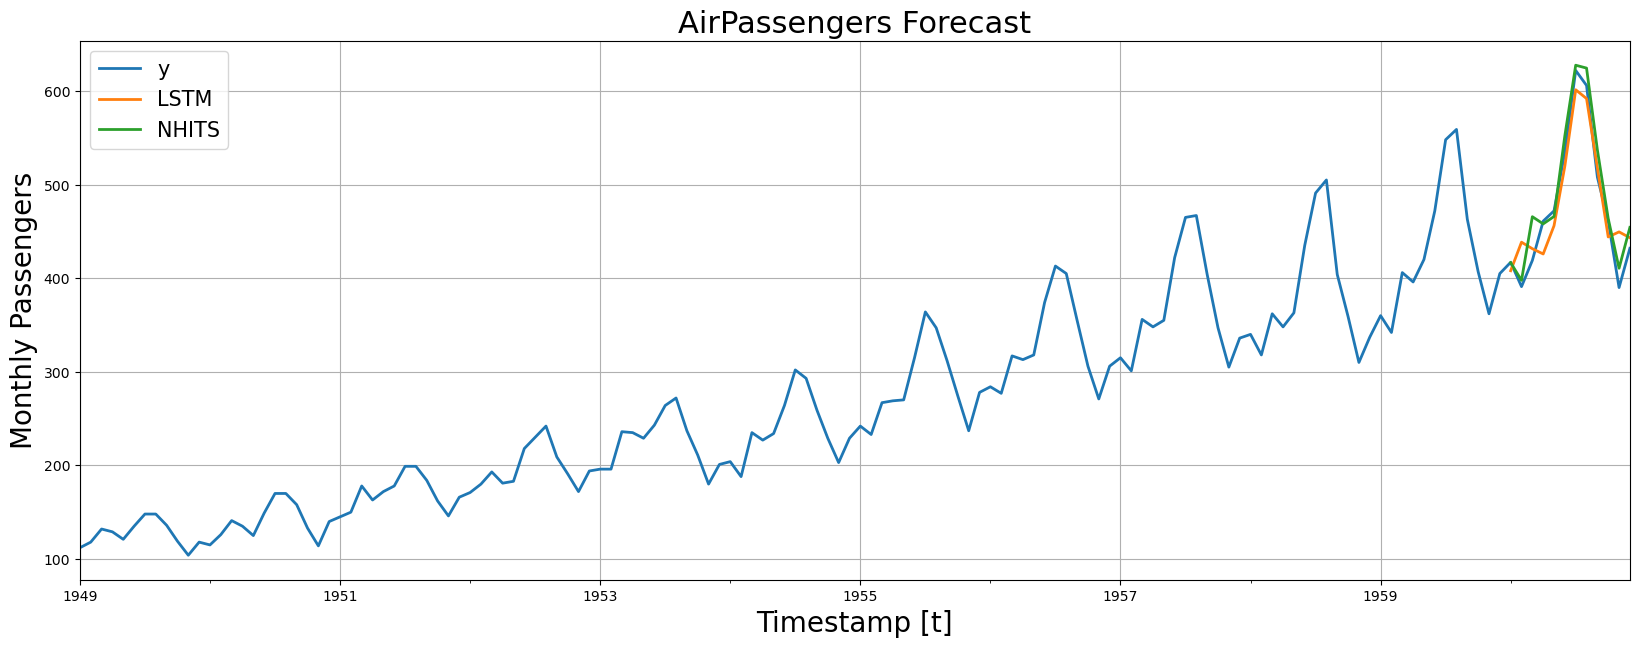

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds']) # Merge forecasts with test data
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
plot_df[['y', 'LSTM', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

:::{.callout-tip}
For this guide we are using a simple `LSTM` model. More recent models, such as `RNN`, `GRU`, and `DilatedRNN` achieve better accuracy than `LSTM` in most settings. The full list of available models is available [here](https://nixtla.github.io/neuralforecast/models.html).
:::

## References
- [Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2020). "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting". International Conference on Learning Representations.](https://arxiv.org/abs/1905.10437)
- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). "N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting". Work in progress paper, submitted to AAAI.](https://arxiv.org/abs/2201.12886)